<a href="https://colab.research.google.com/github/vrose99/ds4bme/blob/master/CaffoFinal_vrose9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn as skl
import statsmodels.formula.api as smf
import statsmodels as sm
import torch
import torch.nn as nn

sns.set()

In [9]:
# Load in Data + Clean it
df = pd.read_csv('https://query.data.world/s/5mzqvsmlvbvkshr7rh35onrfpvol4b')
df = df.dropna()

# make month and year columns 
df['year'] = df['dt'].str[:4].astype(int)
df['month'] = df['dt'].str[5:7].astype(int)

# make latitude and longitude floats instead of strings
df['Latitude'] = df['Latitude'].str[:4].astype(float)
df['Longitude'] = df['Longitude'].str[:4].astype(float)


df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63,3.23,1849,1
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63,3.23,1849,2
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63,3.23,1849,3
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63,3.23,1849,4
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63,3.23,1849,5


In [0]:
# Train - Test Split
trainFraction = .75

sample = np.random.uniform(size = 228175) < trainFraction
trainingDat = df[sample]
testingDat = df[~sample]

In [20]:
# Train + Fit Model
model = smf.ols('AverageTemperature ~ month + year + Longitude + Latitude ', data = trainingDat).fit()
print(model.summary2())

                    Results: Ordinary least squares
Model:              OLS                Adj. R-squared:     0.397       
Dependent Variable: AverageTemperature AIC:                1188991.7176
Date:               2019-10-02 13:32   BIC:                1189041.9727
No. Observations:   171276             Log-Likelihood:     -5.9449e+05 
Df Model:           4                  F-statistic:        2.820e+04   
Df Residuals:       171271             Prob (F-statistic): 0.00        
R-squared:          0.397              Scale:              60.586      
-------------------------------------------------------------------------
               Coef.    Std.Err.       t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------------
Intercept     24.1043     0.6062     39.7635   0.0000   22.9162   25.2924
month          0.2994     0.0055     54.9188   0.0000    0.2887    0.3101
year           0.0030     0.0003      9.5854   0.0000    0.0024    0.0036


In [21]:
x = df[['Latitude','Longitude', 'year', 'month']]
y = df[['AverageTemperature']]

## Add the intercept column
x = sm.tools.add_constant(x)

xtraining = x[sample]
xtesting = x[~sample]
ytraining = y[sample]
ytesting = y[~sample]

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
thresh = np.arange(0,1,0.01).tolist()
yhat = model.predict(xtesting).tolist()
ytesting = ytesting.values
yhat_temp = np.zeros(len(yhat))
results = np.zeros((len(thresh),4))
for j in range(len(thresh)):
  true_pos = 0
  true_neg = 0
  false_pos = 0
  false_neg = 0
  for k in range(len(yhat)):
    if yhat[k] >= thresh[j]:
      yhat_temp[k] = 1
    else:
      yhat_temp[k] = 0
  #print(yhat_temp)
  for i in range(len(yhat)):
    if (yhat_temp[i] == 1) and (ytesting[i] == 1): #true pos
      true_pos += 1
    elif (yhat_temp[i] == 1) and (ytesting[i] == 0): 
      false_pos += 1
    elif (yhat_temp[i] == 0) and (ytesting[i] == 0):
      true_neg += 1
    else:
      false_neg += 1
  results[j,0] = true_pos
  results[j,1] = false_pos
  results[j,2] = true_neg
  results[j,3] = false_neg

In [0]:
sensitivity = np.zeros(len(results[:,0]))
specificity = np.zeros(len(results[:,0]))
#accuracy = np.zeros(len(results[:,0]))
good = results[:,0] + results[:,3]
total = sum(results[1,:])
accuracy = good/total
for i in range(len(results[:,0])):
  sensitivity[i] = results[i,0]/(results[i,0]+results[i,3])
  specificity[i] = results[i,2]/(results[i,2]+results[i,1])
  accuracy[i] = (results[i,0]+results[i,2])/(sum(results[1,:]))
  #print(sum)

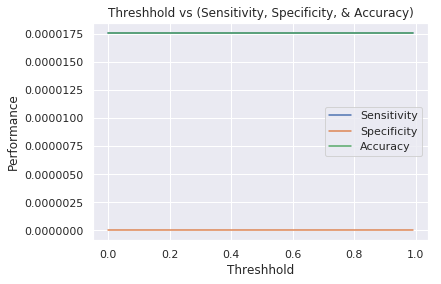

In [24]:
plt.figure()
plt.plot(thresh,sensitivity)
plt.plot(thresh,specificity)
plt.plot(thresh,accuracy)
plt.title('Threshhold vs (Sensitivity, Specificity, & Accuracy)')
plt.ylabel('Performance')
plt.xlabel('Threshhold')
plt.legend(['Sensitivity','Specificity','Accuracy'])